In [38]:
import numpy as np
import torch

In [39]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [40]:
pt_path1 = '../results/sw/sw_CAE_h32_k5_ReZero_default_none_none/sw_CAE_h32_k5_ReZero_default_none_none_sigma_z_b=0.1_sigma_m=0.0001_ens_num=64_infl=1.1_method=ETKF_assimilated.pt'
pt_path2 = '../results/sw/sw_AEflow_b4_k5_ReZero_default_none_none/sw_AEflow_b4_k5_ReZero_default_none_none_sigma_z_b=0.1_sigma_m=0.001_ens_num=64_infl=1.05_method=ETKF_assimilated.pt'
pt_path3 = '../results/sw/sw_SINRv11_default_ReZero_default_none_none/sw_SINRv11_default_ReZero_default_none_none_sigma_z_b=0.01_sigma_m=0.01_ens_num=64_infl=1.02_method=DEnKF_assimilated.pt'
pt_path4 = '../results/sw/sw_CAE_h32_k5_NeuralODE_no_exp_none_none/sw_CAE_h32_k5_NeuralODE_no_exp_none_none_sigma_z_b=0.01_sigma_m=0.01_ens_num=64_infl=1.02_method=DEnKF_assimilated.pt'
pt_path5 = '../results/sw/sw_AEflow_b4_k5_NeuralODE_no_exp_none_none/sw_AEflow_b4_k5_NeuralODE_no_exp_none_none_sigma_z_b=0.01_sigma_m=0.0003_ens_num=64_infl=1.05_method=DEnKF_assimilated.pt'
pt_path6 = '../results/sw/sw_SINRv11_default_NeuralODE_no_exp_scalar_default/sw_SINRv11_default_NeuralODE_no_exp_scalar_default_sigma_z_b=None_sigma_m=None_ens_num=64_infl=1.02_method=ETKF-Q_assimilated.pt'

In [41]:
ass_data1 = torch.load(pt_path1)
ass_data2 = torch.load(pt_path2)
ass_data3 = torch.load(pt_path3)

ass_data4 = torch.load(pt_path4)
ass_data5 = torch.load(pt_path5)
ass_data6 = torch.load(pt_path6)
ass_data1['xx_a'].shape

torch.Size([199, 1024])

In [42]:
import sys

sys.path.append('../')
from datasets import MetaData

dataset_ts_path = '/home/lizhuoyuan/datasets/shallow_water/cached_meta_ts.pt'
dataset_ts:MetaData = torch.load(dataset_ts_path)
dataset_ts.trajs[0].shape

torch.Size([240, 128, 64, 2])

In [43]:
import os
import logging
from datasets import load_dataset

logger = logging.getLogger()

In [44]:
from components import EncoderDecoder, LatentDynamics, UncertaintyEst
from components import get_encoder_decoder, get_latent_dynamics, get_uncertainty_est

In [45]:
import hydra
from hydra import compose, initialize
from hydra.core.config_store import ConfigStore
from omegaconf import OmegaConf

from configs.assimilate.assimilate_conf_schema import AssimilateConfig
from configs.finetune.finetune_conf_schema import FineTuneConfig
from configs.conf_schema import EDConfig, LDConfig, UEConfig, DatasetConfig
from metrics import get_metrics
from common import create_logger, set_seed, transform_state_dict


cs = ConfigStore.instance()
cs.store(name="assimilate_schema", node=AssimilateConfig)
cs.store(name="finetune_schema", node=FineTuneConfig)
cs.store(group="encoder_decoder", name="encoder_decoder_schema", node=EDConfig)
cs.store(group="latent_dynamics", name="latent_dynamics_schema", node=LDConfig)
cs.store(group="uncertainty_est", name="uncertainty_est_schema", node=UEConfig)
cs.store(name="dataset_schema", group='dataset', node=DatasetConfig)

with initialize(config_path='../configs/finetune', version_base='1.2'):
    cfg1 = compose(config_name='config', overrides=[
        "encoder_decoder=ablation/cae/h32_k5",
        'latent_dynamics=default_rezero',
    ])
    cfg2 = compose(config_name='config', overrides=[
        "encoder_decoder=ablation/aeflow/b4_k5",
        'latent_dynamics=default_rezero',
    ])
    cfg3 = compose(config_name='config', overrides=[
        "encoder_decoder=default_sinr_v11",
        'latent_dynamics=default_rezero',
    ])
    
    cfg4 = compose(config_name='config', overrides=[
        "encoder_decoder=ablation/cae/h32_k5",
        'latent_dynamics=ablation/neuralode/no_exp',
    ])
    cfg5 = compose(config_name='config', overrides=[
        "encoder_decoder=ablation/aeflow/b4_k5",
        'latent_dynamics=ablation/neuralode/no_exp',
    ])
    cfg6 = compose(config_name='config', overrides=[
        "encoder_decoder=default_sinr_v11",
        'latent_dynamics=ablation/neuralode/no_exp',
    ])

In [46]:
def conf_prepare(cfg: FineTuneConfig):

    cfg.encoder_decoder.arch_params.state_channels = cfg.dataset.snapshot_shape[-1]
    cfg.encoder_decoder.arch_params.state_size = cfg.dataset.snapshot_shape[:-1]
    cfg.latent_dynamics.latent_dim = cfg.encoder_decoder.latent_dim
    
    cfg.ckpt_path=os.path.join('..', cfg.ckpt_path)


conf_prepare(cfg1)
conf_prepare(cfg2)
conf_prepare(cfg3)

conf_prepare(cfg4)
conf_prepare(cfg5)
conf_prepare(cfg6)

print(OmegaConf.to_yaml(cfg1))

name: ${dataset.name}_${encoder_decoder.name}_${latent_dynamics.name}
phase: finetune
seed: 2357
num_gpus: 0
master_port: 23571
ckpt_path: ../../ckpts/finetune/sw_CAE_h32_k5_ReZero_default.pt
nepochs: 1000
bs: ${encoder_decoder.training_params.bs}
eval_freq: 10
mix_precision: false
pretrain_name: ${dataset.name}_${encoder_decoder.name}
pretrain_ckpt_path: ../ckpts/pretrain/${pretrain_name}.pt
dataset:
  name: sw
  root_path: /home/lizhuoyuan/datasets/shallow_water
  snapshot_shape:
  - 128
  - 64
  - 2
  read_cache: true
  normalize: true
  normalize_mean: null
  normalize_std: null
  window_width: 10
  offgrid: false
encoder_decoder:
  model_name: CAE
  cfg_name: h32_k5
  name: ${encoder_decoder.model_name}_${encoder_decoder.cfg_name}
  latent_dim: 1024
  need_train: true
  need_cache: false
  arch_params:
    hidden_channels: 32
    latent_channels: 8
    kernel_size: 5
    padding_type:
    - circular
    - replicate
    nresblocks: null
    state_size:
    - 128
    - 64
    state_

In [47]:
dataset_class = load_dataset(logger, cfg=cfg1.dataset)
dataset_tr = dataset_class.get_metadata('tr')
dataset_va = dataset_class.get_metadata('va')
dataset_ts = dataset_class.get_metadata('ts')

In [48]:
def get_model(cfg: FineTuneConfig):
    if cfg.encoder_decoder.need_cache:
        loss_fn_inner_loop = get_metrics(name=cfg.encoder_decoder.arch_params.inner_loop_loss_fn,
                                         phi_theta=dataset_va.coords['coord_latlon'])
    else:
        loss_fn_inner_loop = None

    model: EncoderDecoder = get_encoder_decoder(logger,
                                                name=cfg.encoder_decoder.model_name,
                                                loss_fn_inner_loop=loss_fn_inner_loop,
                                                **cfg.encoder_decoder.arch_params)
    ckpt = torch.load(cfg.ckpt_path, map_location='cpu')
    model.load_state_dict(transform_state_dict(ckpt['ed']))

    return model

In [49]:
model1 = get_model(cfg1)
model2 = get_model(cfg2)
model3 = get_model(cfg3)
model4 = get_model(cfg4)
model5 = get_model(cfg5)
model6 = get_model(cfg6)

In [50]:
dataset_va.coords['coord_latlon'].shape

torch.Size([128, 64, 2])

In [51]:
ass_data3['xx_a'].shape

torch.Size([199, 400])

In [52]:
xx_a1 = model1(ass_data1['xx_a'], operation='decode')
xx_a2 = model2(ass_data2['xx_a'], operation='decode')
xx_a3 = model3(ass_data3['xx_a'], operation='decode', coord_latlon=dataset_va.coords['coord_latlon'][None, ...])
xx_a4 = model4(ass_data4['xx_a'], operation='decode')
xx_a5 = model5(ass_data5['xx_a'], operation='decode')
xx_a6 = model6(ass_data6['xx_a'], operation='decode', coord_latlon=dataset_va.coords['coord_latlon'][None, ...])

In [53]:
xx_a1 = xx_a1.detach().cpu().numpy()
xx_a2 = xx_a2.detach().cpu().numpy()
xx_a3 = xx_a3.detach().cpu().numpy()
xx_a4 = xx_a4.detach().cpu().numpy()
xx_a5 = xx_a5.detach().cpu().numpy()
xx_a6 = xx_a6.detach().cpu().numpy()
xx_t = dataset_ts.trajs[0].detach().cpu().numpy()

In [54]:
print(f'{xx_a1.shape=},\n{xx_a2.shape=},\n{xx_a3.shape=},\n{xx_t.shape=}')

xx_a1.shape=(199, 128, 64, 2),
xx_a2.shape=(199, 128, 64, 2),
xx_a3.shape=(199, 128, 64, 2),
xx_t.shape=(240, 128, 64, 2)


In [55]:
xx_t = xx_t[1:200]

In [56]:
from typing import *
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

vmin=-3, vmax=3


/tmp/ipykernel_28905/707781850.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


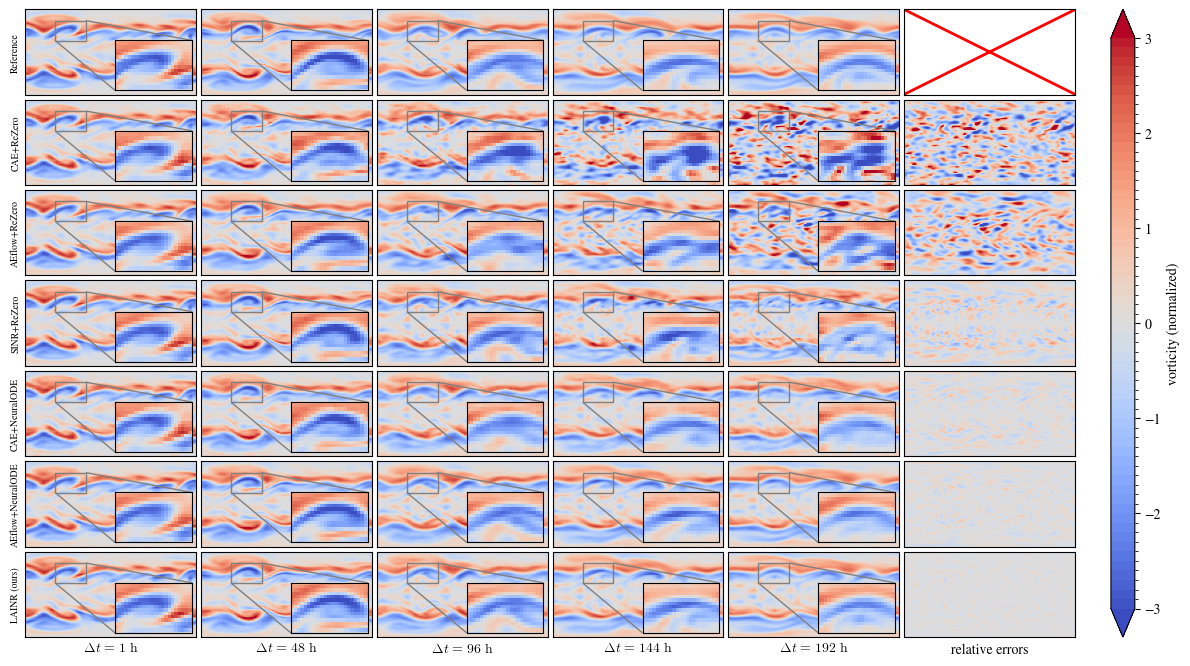

In [94]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes


if isinstance(xx_a1, torch.Tensor):
    xx_a1 = xx_a1.numpy()
    xx_a2 = xx_a2.numpy()
    xx_a3 = xx_a3.numpy()
    xx_a4 = xx_a4.numpy()
    xx_a5 = xx_a5.numpy()
    xx_a6 = xx_a6.numpy()
    xx_t = xx_t.numpy()

fig = plt.figure(figsize=(12, 8))

# ------------------------------ height ------------------------------

imgrid = ImageGrid(fig, 111, nrows_ncols=(1 + 3 + 3, 6), axes_pad=.05,
                   #    share_all=True,
                   cbar_pad='3%',
                   cbar_size="2%",
                   cbar_location="right", cbar_mode="single")  # [0, 48, 96, 144, 192]

# axs: Iterable[Iterable[Axes]]
idz = 0

vmin = -3
vmax = 3

zoom_in = True

cmap = mpl.cm.coolwarm
bounds = list(np.linspace(vmin, vmax, 61))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

print(f'{vmin=}, {vmax=}')

models = ['CAE+ReZero', 'AEflow+ReZero', 'SINR+ReZero',
          'CAE+NeuralODE', 'AEflow+NeuralODE', 'LAINR (ours)']
xlabels = ['Reference'] + models
steps = [1] + list(range(48, 48 * 5, 48))

extent = [0, 127, 0, 63]

for idx, xx in enumerate([xx_t, xx_a1, xx_a2, xx_a3, xx_a4, xx_a5, xx_a6]):
    for idy, step in enumerate(steps):
        im = imgrid[idz].imshow(xx[step - 1][..., 1].T,
                                origin='lower',
                                cmap=cmap, norm=norm)
        if idy == 0:
            imgrid[idz].set_ylabel(xlabels[idx], fontsize=7)

        if zoom_in:

            zfig = xx[step - 1][..., 1].T

            axins2 = zoomed_inset_axes(imgrid[idz], zoom=2.5, loc='lower right',borderpad=0.3)
            axins2.imshow(zfig, origin="lower", extent=extent, cmap=cmap, norm=norm)
            axins2.set_xticks([])
            axins2.set_yticks([])

            # subregion of the original image
            # x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9
            axins2.set_xlim(22, 45)
            axins2.set_ylim(40, 55)
            # fix the number of ticks on the inset axes
            axins2.yaxis.get_major_locator().set_params(nbins=7)
            axins2.xaxis.get_major_locator().set_params(nbins=7)
            axins2.tick_params(labelleft=False, labelbottom=False)

        # draw a bbox of the region of the inset axes in the parent axes and
        # connecting lines between the bbox and the inset axes area
        mark_inset(imgrid[idz], axins2, loc1=1, loc2=3, fc="none", ec="0.5")

        idz += 1
        
    if idx > 0:
        imgrid[idz].imshow(xx[-1][..., 1].T - xx_t[-1][..., 1].T,
                           origin='lower',
                           cmap=cmap, norm=norm)
    else:
        imgrid[idz].plot([0, 127], [0, 63], color='r', linewidth=2)
        imgrid[idz].plot([0, 127], [63, 0], color='r', linewidth=2)
        
    idz += 1

imgrid[6 * 6 + 0].set_xlabel(f'$\\Delta t={steps[0]}$ h', usetex=True)
imgrid[6 * 6 + 1].set_xlabel(f'$\\Delta t={steps[1]}$ h', usetex=True)
imgrid[6 * 6 + 2].set_xlabel(f'$\\Delta t={steps[2]}$ h', usetex=True)
imgrid[6 * 6 + 3].set_xlabel(f'$\\Delta t={steps[3]}$ h', usetex=True)
imgrid[6 * 6 + 4].set_xlabel(f'$\\Delta t={steps[4]}$ h', usetex=True)
imgrid[6 * 6 + 5].set_xlabel(f'relative errors')

for ax in imgrid:
    ax.set_xticks([])
    ax.set_yticks([])

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=imgrid.cbar_axes[0],
    cax=imgrid.cbar_axes[0],
    orientation='vertical', label='vorticity (normalized)')

cbar.set_ticks(list(range(-3, 4)), minor=False)

plt.tight_layout()
plt.savefig('sw-stamppic-all-vorticity.pdf')
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes


if isinstance(xx_a1, torch.Tensor):
    xx_a1 = xx_a1.numpy()
    xx_a2 = xx_a2.numpy()
    xx_a3 = xx_a3.numpy()
    xx_a4 = xx_a4.numpy()
    xx_a5 = xx_a5.numpy()
    xx_a6 = xx_a6.numpy()
    xx_t = xx_t.numpy()

fig = plt.figure(figsize=(12, 8))

# ------------------------------ height ------------------------------

imgrid = ImageGrid(fig, 111, nrows_ncols=(1 + 3 + 3, 6), axes_pad=.05,
                   #    share_all=True,
                   cbar_pad='3%',
                   cbar_size="2%",
                   cbar_location="right", cbar_mode="single")  # [0, 48, 96, 144, 192]

# axs: Iterable[Iterable[Axes]]
idz = 0

vmin = -3
vmax = 3

zoom_in = False

cmap = mpl.cm.coolwarm
bounds = list(np.linspace(vmin, vmax, 61))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

print(f'{vmin=}, {vmax=}')

models = ['CAE+ReZero', 'AEflow+ReZero', 'SINR+ReZero',
          'CAE+NeuralODE', 'AEflow+NeuralODE', 'LAINR (ours)']
xlabels = ['Reference'] + models
steps = [1] + list(range(48, 48 * 5, 48))

extent = [0, 127, 0, 63]

for idx, xx in enumerate([xx_t, xx_a1, xx_a2, xx_a3, xx_a4, xx_a5, xx_a6]):
    for idy, step in enumerate(steps):
        im = imgrid[idz].imshow(xx[step - 1][..., 1].T,
                                origin='lower',
                                cmap=cmap, norm=norm)
        if idy == 0:
            imgrid[idz].set_ylabel(xlabels[idx], fontsize=7)

        if zoom_in:

            zfig = xx[step - 1][..., 1].T

            axins2 = zoomed_inset_axes(imgrid[idz], zoom=2.5, loc='lower right', borderpad=0.3)
            axins2.imshow(zfig, origin="lower", extent=extent, cmap=cmap, norm=norm)
            axins2.set_xticks([])
            axins2.set_yticks([])

            # subregion of the original image
            # x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9
            axins2.set_xlim(22, 45)
            axins2.set_ylim(40, 55)
            # fix the number of ticks on the inset axes
            axins2.yaxis.get_major_locator().set_params(nbins=7)
            axins2.xaxis.get_major_locator().set_params(nbins=7)
            axins2.tick_params(labelleft=False, labelbottom=False)

        # draw a bbox of the region of the inset axes in the parent axes and
        # connecting lines between the bbox and the inset axes area
        mark_inset(imgrid[idz], axins2, loc1=1, loc2=3, fc="none", ec="0.5")

        idz += 1

    if idx > 0:
        imgrid[idz].imshow(xx[-1][..., 1].T - xx_t[-1][..., 1].T,
                           origin='lower',
                           cmap=cmap, norm=norm)
    else:
        imgrid[idz].plot([0, 127], [0, 63], color='r', linewidth=2)
        imgrid[idz].plot([0, 127], [63, 0], color='r', linewidth=2)

    idz += 1

imgrid[6 * 6 + 0].set_xlabel(f'$\\Delta t={steps[0]}$ h', usetex=True)
imgrid[6 * 6 + 1].set_xlabel(f'$\\Delta t={steps[1]}$ h', usetex=True)
imgrid[6 * 6 + 2].set_xlabel(f'$\\Delta t={steps[2]}$ h', usetex=True)
imgrid[6 * 6 + 3].set_xlabel(f'$\\Delta t={steps[3]}$ h', usetex=True)
imgrid[6 * 6 + 4].set_xlabel(f'$\\Delta t={steps[4]}$ h', usetex=True)
imgrid[6 * 6 + 5].set_xlabel(f'relative errors')

for ax in imgrid:
    ax.set_xticks([])
    ax.set_yticks([])

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=imgrid.cbar_axes[0],
    cax=imgrid.cbar_axes[0],
    orientation='vertical', label='vorticity (normalized)')

cbar.set_ticks(list(range(-3, 4)), minor=False)

plt.tight_layout()
plt.savefig('sw-stamppic-all-vorticity.pdf')
plt.show()

In [90]:
import pandas as pd
import seaborn as sns

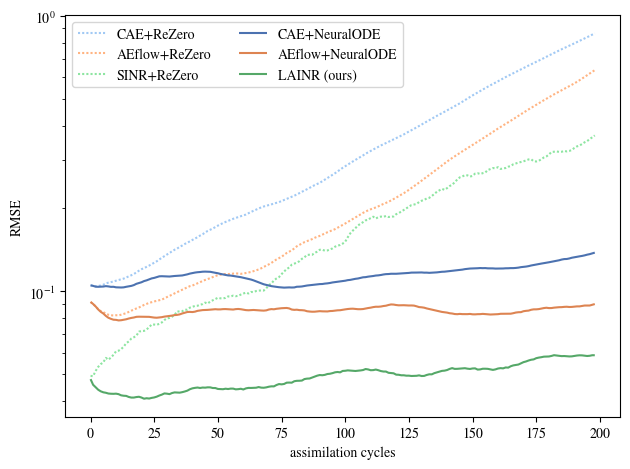

In [93]:
rmse_fn = get_metrics('weighted_root', phi_theta=dataset_va.coords['coord_latlon'])
if isinstance(xx_a1, np.ndarray):
    xx_a1 = torch.from_numpy(xx_a1)
    xx_a2 = torch.from_numpy(xx_a2)
    xx_a3 = torch.from_numpy(xx_a3)
    xx_a4 = torch.from_numpy(xx_a4)
    xx_a5 = torch.from_numpy(xx_a5)
    xx_a6 = torch.from_numpy(xx_a6)
    xx_t = torch.from_numpy(xx_t)

colors = sns.palettes.color_palette('pastel', 3) + sns.palettes.color_palette('deep', 3)

rows_list = []

for idx, xx in enumerate([xx_a1, xx_a2, xx_a3, xx_a4, xx_a5, xx_a6]):
    for step, (x, x_t) in enumerate(zip(xx.split(1), xx_t.split(1))):
        rmse = rmse_fn(x, x_t, feature_sep=True)
        rows_list.append({'model': models[idx], 'step': step, 'rmse': rmse.mean().item()})

df = pd.DataFrame(rows_list)

ax = sns.lineplot(data=df, x='step', y='rmse', hue='model', style='model',
                  dashes=[(1, 1),] * 3 + [(1, 0),] * 3, palette=colors)
ax.set_yscale('log')
ax.set_xlabel('assimilation cycles')
ax.set_ylabel('RMSE')
ax.legend(ncol=2)
plt.tight_layout()
plt.savefig('sw-ass-rmse-all.pdf', bbox_inches=0.)
# rmse1 = rmse_fn(torch.from_numpy(xx_a1), torch.from_numpy(xx_t), feature_sep=True)
# rmse2 = rmse_fn(torch.from_numpy(xx_a2), torch.from_numpy(xx_t), feature_sep=True)
# rmse3 = rmse_fn(torch.from_numpy(xx_a3), torch.from_numpy(xx_t), feature_sep=True)

In [92]:
rmse_fn = get_metrics('weighted_root', phi_theta=dataset_va.coords['coord_latlon'])
xx_a1 = torch.from_numpy(xx_a1)
xx_a2 = torch.from_numpy(xx_a2)
xx_a3 = torch.from_numpy(xx_a3)
xx_t = torch.from_numpy(xx_t)

models = ['CAE', 'AEflow', 'LAINR (ours)']
rows_list = []

for idx, xx in enumerate([xx_a1, xx_a2, xx_a3]):
    for step, (x, x_t) in enumerate(zip(xx.split(1), xx_t.split(1))):
        rmse = rmse_fn(x, x_t, feature_sep=True)
        rows_list.append({'model': models[idx], 'step': step, 'feature': 'height', 'rmse': rmse[0].item()})
        rows_list.append({'model': models[idx], 'step': step, 'feature': 'vorticity', 'rmse': rmse[1].item()})

df = pd.DataFrame(rows_list)

df
# rmse1 = rmse_fn(torch.from_numpy(xx_a1), torch.from_numpy(xx_t), feature_sep=True)
# rmse2 = rmse_fn(torch.from_numpy(xx_a2), torch.from_numpy(xx_t), feature_sep=True)
# rmse3 = rmse_fn(torch.from_numpy(xx_a3), torch.from_numpy(xx_t), feature_sep=True)

TypeError: expected np.ndarray (got Tensor)

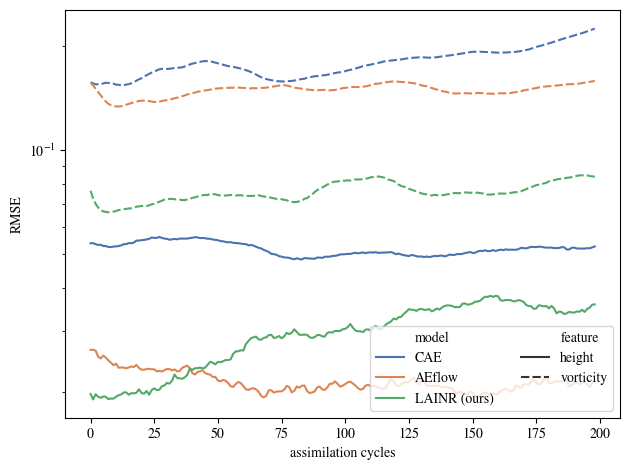

In [ ]:
ax = sns.lineplot(data=df, x='step', y='rmse', hue='model', style='feature', palette='deep')
ax.set_yscale('log')
ax.set_xlabel('assimilation cycles')
ax.set_ylabel('RMSE')
plt.legend(ncol=2)
plt.tight_layout()
# plt.savefig('sw-rmse.pdf')